In [ ]:
from avcv.all import *
import torch

In [ ]:
class Label:
    def __init__(self, label, video):
        self.label = label
        self.video = video
        
    def check_action_at_frame_idx(self, i):
        if isinstance(i, int):
            i = i/self.video.fps
            
        actions = []
        for action in self.label['annotation']['actionAnnotationList']:
            if i >= action['start'] and i < action['end']:
                action_idx = action['action']
                action_name = self.actionid2name[action_idx]
                actions.append(action_name)
        return actions
    @property
    def actionid2name(self):
        if hasattr(self, '_actionid2name'):
            return self._actionid2name
        ret = dict()
        for actionLabel in self.label['config']['actionLabelData']:
            ret[actionLabel['id']] = actionLabel['name']
        self._actionid2name = ret
        return ret

In [ ]:
def get_data(label_path, label_type='food'):
    if label_type == 'food':
        video_name = get_name(label_path)
        pred_json_path = f'/home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/{video_name}/annotations/pred_mb2_face_food.json'
        root_video_name = '_'.join(video_name.split('_')[:-2])
        video_path = label_path.replace('.json', '.mp4')
        raw_feat_path = pred_json_path.replace('.json', '_2_raw_outputs.pkl')
    elif label_type == 'phone/cigarret':
        pred_json_path = f'/home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/{video_name}/annotations/pred_mb2_face_food.json'
        t = 'smoking' if 'smoking' in video_name else 'mobile_usage'
        label_path = f'/data/DMS_Behavior_Detection/mobile_cigarret_foreignerUS/training/yoon/{t}/{video_name}.json'
        video_path = label_path.replace('.json', '.mp4')
        raw_feat_path = pred_json_path.replace('.json', '_2_raw_outputs.pkl')
    else:
        raise NotImplementedError
    assert osp.exists(pred_json_path), f'404 {pred_json_path}'
    assert osp.exists(label_path), f'404 {label_path}'
    assert osp.exists(video_path), f'404 {video_path}'
    assert osp.exists(raw_feat_path), f'404 {raw_feat_path}'
    
    return dict(
        pred_json_path=pred_json_path,
        label_path = label_path,
        video_path=video_path,
        raw_feat_path=raw_feat_path
    )

In [ ]:
list_json_paths = []


label_paths  = glob('/data/DMS_Behavior_Detection/RawVideos/Action_Eating/**/*.json', recursive=True)
for label_path in label_paths:
    try:
        json_paths = get_data(label_path, 'food')
        list_json_paths.append(json_paths)
    except Exception as e:
        print(e)
        pass

label_paths  = glob('/data/DMS_Behavior_Detection/mobile_cigarret_foreignerUS/*/**/*.json', recursive=True)
print(f'{len(label_paths)=}')
for label_path in label_paths:
    try:
        json_paths = get_data(label_path, 'food')
        list_json_paths.append(json_paths)
    except Exception as e:
        print(e)
        pass
len(list_json_paths)

404 /home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_eating_0017/annotations/pred_mb2_face_food_2_raw_outputs.pkl
404 /home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/hoangnh42_Sensing_Session0_CAMc_1b_2b_3a_4c_5b_6b_7b_8a_9a_10b_11b_12b_13b_14a_15b_16f_17a_18a_19a_20b_eating_0011/annotations/pred_mb2_face_food_2_raw_outputs.pkl
len(label_paths)=67


107

In [ ]:
cats = mmcv.load(list_json_paths[0]['pred_json_path'])['categories']
cats

[{'id': 1, 'name': 'cigarette'},
 {'id': 2, 'name': 'food/drink'},
 {'id': 3, 'name': 'phone'},
 {'id': 4, 'name': 'face'},
 {'id': 5, 'name': 'eye'},
 {'id': 6, 'name': 'mouth'}]

## Read 2d video feat

In [ ]:
def convert_flatten_to_2d_feature(flatten_sample):
    feat_sizes = [416//8, 416//16, 416//32]
    # reg_orig_shape = np.array(reg_orig_shape)**2
    cur_i = 0
    feats = []
    for feat_size in feat_sizes:
        a = cur_i
        b = a+feat_size**2
        cur_i = b
        feats.append(flatten_sample[a:b].reshape(feat_size, feat_size, -1))
    return feats

def read_raw_feat_one_video(path):
    data = dict(mmcv.load(path))
    # for k in data:
    #     data[k] = convert_flatten_to_2d_feature(data[k])
    return data
    # list_json_paths[0]['raw_feat_path']

In [ ]:
# 

In [ ]:
def anns2tensor(img, anns):
    h, w = img['height'], img['width']
    tensor = []
    for ann in anns:
        x,y,w,h = ann['bbox']
        x /=img['width']
        w /=img['width']
        y /=img['height']
        h /=img['height']
        s = ann['score']
        cat = ann['category_id']
        tensor.append([x,y,w,h,s, cat])
    return np.array(tensor)

In [ ]:
def collect_data(inp):
    index, json_paths = inp
    v = mmcv.VideoReader(json_paths['video_path'])
    # t = len(v)
    label = Label(mmcv.load(json_paths['label_path']), v)
    cc = CocoDataset(json_paths['pred_json_path'])
    data = []
    raw_feat2d = read_raw_feat_one_video(json_paths['raw_feat_path'])
    for i, frame in enumerate(v):
        actions = label.check_action_at_frame_idx(i)
        anns = cc.gt.imgToAnns[i]
        img = cc.gt.imgs[i]
        tensor = None#anns2tensor(img, anns)
        img_path = osp.join(cc.img_dir, img['file_name'])
        
        data.append((tensor, actions[0] if len(actions) else 'none' , 
                     index, img_path, img['id'], raw_feat2d[img['id']]))
        
    return data
data = multi_thread(collect_data, list(enumerate(list_json_paths)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [01:52<00:00,  1.05s/it]


In [ ]:
all_data = []
for _ in data: all_data += _

df = pd.DataFrame(all_data, columns=['tensor', 'action', 'video_index', 'img_path', 'img_id', 'feat1d'])
ids = df[df['action'] == 'smocking'].index
df.loc[ids, 'action'] = 'smoking'

In [ ]:
_id2action = dict(enumerate(df['action'].apply(str).unique().tolist()))
action2id = {v:k for k, v in _id2action.items()}
print(action2id)

def get_y(actions):
    return action2id[str(actions)]

def get_x_tensor(tensor):
    zt = np.zeros([1,6], dtype=np.float32)
    def get_tensor_cat(cat):
        if len(tensor) == 0:
            return zt
        
        _t = tensor[tensor[:,-1] ==cat]
        
        if len(_t):
            max_id = _t[:,-2].argmax()
            _t = _t[max_id][None]
        else:
            return zt
            
        return _t
    return np.concatenate([get_tensor_cat(i) for i in range(1, 7)])

{'eating': 0, 'none': 1, 'mobile usage': 2, 'smoking': 3}


In [ ]:
def get_M(input_size = [224, 416], num_cls=6):
    """
        return list of mapping [old_start, old_end, new_start, new_end ]
    """
    M = []
    target_f_size = []
    
    cur_i = 0
    o_cur_i = 0

    for i in [8,16,32]:
        h, w = input_size
        _h, _w = h//i, w//i
        _oh = _ow = 416//i

        a, b = cur_i,cur_i +_h*_w
        oa, ob = o_cur_i,o_cur_i +_oh*_oh
        cur_i = b
        o_cur_i = ob
        M.append([oa, ob, _h*_w, _h, _w])
        
    return M, _h*_w*num_cls
INP_SHAPE = (416,416)
INP_SHAPE_STR = '_'.join([str(_) for _ in INP_SHAPE])
M, IN_CHANNEL_CLS = get_M(INP_SHAPE)
M, IN_CHANNEL_CLS, INP_SHAPE_STR

([[0, 2704, 2704, 52, 52],
  [2704, 3380, 676, 26, 26],
  [3380, 3549, 169, 13, 13]],
 1014,
 '416_416')

In [ ]:

def convert_f(f):
    fs = []
    for oa,ob,ab,_,_ in M:
        # print(oa,ob,ab)
        fs.append(f[oa:ob][:ab].reshape(-1, 11))
    return np.concatenate(fs)

In [ ]:
IN_CHANNEL_CLS

1014

In [ ]:
df['x'] = df.feat1d.apply(convert_f)

In [ ]:
df['x'].iloc[0].shape

(3549, 11)

In [ ]:
df['y'] = df['action'].apply(get_y)

In [ ]:
from sklearn.model_selection import train_test_split

labels = df.action.unique().tolist()
labels

df_train = df[df.video_index.apply(lambda i: i % 5 != 0)]
df_val = df[df.video_index.apply(lambda i: i % 5 == 0)]
print(f'{len(df_train)=}, {len(df_val)=}')

def df2xy(df):
    return np.array(df.x.values.tolist()).reshape(len(df), -1), np.array(df.y.tolist())

xtrain, ytrain = df2xy(df_train)
xval, yval = df2xy(df_val)

len(df_train)=65748, len(df_val)=18277


## Tree

In [ ]:


# from sklearn.datasets import load_diabetes
# from sklearn.model_selection import cross_val_score
# from sklearn.tree import DecisionTreeClassifier
# # regressor = DecisionTreeRegressor(random_state=0)
# # cross_val_score(regressor, X_train, y_train, cv=10)

# clf = DecisionTreeClassifier(max_depth=3, random_state = 42)

# clf.fit(xtrain, ytrain)

# list_new_categories = ['cigarette', 'food/drink', 'phone', 'face', 'eye', 'mouth']

# len(df_train), len(df_val)

# list_cats = [_['name'] for _ in mmcv.load(list_json_paths[0]['pred_json_path'])['categories']]

# from sklearn import tree

# import matplotlib.pyplot as plt

# plt.figure(figsize=(30,10), facecolor ='k')
# feature_names = []
# for i in range(6):
#     for j in range(6):
#         part = list_cats
#         name = ['x', 'y', 'w', 'h', 'score', 'category'][j]
#         feature_names.append('{}-{}'.format(part, name))

# a = tree.plot_tree(clf,

#                    feature_names = feature_names,

#                    class_names = labels,

#                    rounded = True,

#                    filled = False,

#                    fontsize=14
#                   )
# plt.show()
# test_pred_decision_tree = clf.predict(xval)

In [ ]:
# df.groupby('action').size()

In [ ]:
# from sklearn import metrics

# import seaborn as sns

# import matplotlib.pyplot as plt

# confusion_matrix = metrics.confusion_matrix(yval,  

#                                             test_pred_decision_tree)

# matrix_df = pd.DataFrame(confusion_matrix)

# ax = plt.axes()

# sns.set(font_scale=1.3)

# plt.figure(figsize=(10,7))

# sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")

# ax.set_title('Confusion Matrix - Decision Tree')

# ax.set_xlabel("Predicted label", fontsize =15)

# ax.set_xticklabels(labels)

# ax.set_ylabel("True Label", fontsize=15)

# ax.set_yticklabels(list(labels), rotation = 0)

# plt.show()

# Simple classifier

In [ ]:
from ple.all import *

## SimpleCLS

In [ ]:
import torch.nn as nn, torch
class SimpleCLS2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(IN_CHANNEL_CLS, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = x[...,4:5]*x[...,5:]
        xs = []
        cur_i = 0
        for i, _ in enumerate(M):
            h,w = _[-2:]
            _x = x[:, cur_i:cur_i+h*w].reshape([-1, h, w, 6]).permute([0,3,1,2])
            
            pool_size = 2**(2-i)
            _x = nn.functional.max_pool2d(_x, pool_size)
            cur_i += h*w
            xs.append(_x)

        fuse = sum(xs)
        fuse = fuse.flatten(1)
        return self.layers(fuse)

[{'id': 1, 'name': 'cigarette'},
 {'id': 2, 'name': 'food/drink'},
 {'id': 3, 'name': 'phone'},
 {'id': 4, 'name': 'face'},
 {'id': 5, 'name': 'eye'},
 {'id': 6, 'name': 'mouth'}]

## MyLit

In [ ]:
class MyLit(LitModel):
    pass


## PLData

In [ ]:
from ple.all import *
import torch.utils.data as td
import pytorch_lightning as pl
from fastcore.all import *

def convert_feat18_to_feat15(x):
    return x[:,[i for i in range(18) if not i%6==5]].copy()

class DS:
    def __init__(self, x,y):
        self.x, self.y = x,y
        
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx].astype(np.float32).reshape(-1, 11), self.y[idx].astype(np.int64)

class PLData(pl.LightningDataModule):
    def __init__(self, **kwargs):
        super().__init__()
        store_attr(**kwargs)

    def train_dataloader(self):
        dataset = DS(xtrain, ytrain)
        return td.DataLoader(dataset, self.batch_size, num_workers=self.num_workers, drop_last=True, shuffle=True)

    def val_dataloader(self):
        dataset = DS(xval, yval)
        return td.DataLoader(dataset, self.batch_size, num_workers=self.num_workers,drop_last=True)

In [ ]:
ds = DS(xtrain, ytrain)

In [ ]:
# from tools.demo import Predictor
# predictor = Predictor(model, exp)
# @patch
# def img_preproc(self:Predictor, img):
#     img_info = {"id": 0}
#     if isinstance(img, str):
#         img_info["file_name"] = os.path.basename(img)
#         img = cv2.imread(img)
#     else:
#         img_info["file_name"] = None

#     height, width = img.shape[:2]
#     img_info["height"] = height
#     img_info["width"] = width
#     img_info["raw_img"] = img

#     ratio = min(self.test_size[0] / img.shape[0], self.test_size[1] / img.shape[1])
#     img_info["ratio"] = ratio

#     img, _ = self.preproc(img, None, self.test_size)
#     img = torch.from_numpy(img).unsqueeze(0)
#     img = img.float()
#     if self.device == "gpu":
#         img = img.cuda()
#         if self.fp16:
#             img = img.half()  # to FP16

#     return img, img_info

In [ ]:
# ds

## TriStageExp

In [ ]:
class TriStageExp(BaseExp):

    def __init__(self, exp_name='EXPNAME', 
                 batch_size=64, 
                 num_workers=2, 
                 devices=2,
                 strategy='dp', 
                 **kwargs):
        super().__init__()
        store_attr(**kwargs)

    def get_model(self):
        dl = self.get_data_loader().train_dataloader()
        sched = fn_schedule_cosine_with_warmpup_decay_timm(
            num_epochs=self.max_epochs,
            num_steps_per_epoch=len(dl)//self.devices,
            num_epochs_per_cycle=self.max_epochs//self.num_lr_cycles,
            min_lr=1/100,
            cycle_decay=0.7,
        )
        optim = lambda params:torch.optim.Adam(params)

        return MyLit(self.model, create_optimizer_fn=optim,
                                   create_lr_scheduler_fn=sched, loss_fn=FocalLoss())

    def get_data_loader(self):
        return PLData(batch_size=self.batch_size, num_workers=self.num_workers)

    def get_trainer(self, **kwargs):
        from ple.trainer import get_trainer
        return get_trainer(self.exp_name, 
                              max_epochs=self.max_epochs, 
                              gpus=self.devices,
                           strategy=self.strategy,
                           **kwargs,

                          )
exp = TriStageExp(exp_name=f'simple_nn/{INP_SHAPE_STR}', batch_size=256, devices=1, model=SimpleCLS2D(), max_epochs=30)
# print(exp)

In [ ]:
lit_model = exp.get_model()


2022-09-20 10:52:27.821 | INFO     | ple.lit_model:fn_schedule_cosine_with_warmpup_decay_timm:66 - num_cycles=3


In [ ]:
trainer = exp.get_trainer()

trainer.fit(lit_model, exp.get_data_loader())

2022-09-20 10:52:28.018 | INFO     | ple.trainer:get_trainer:34 - Log root dir: lightning_logs/simple_nn/416_416/00


In [ ]:
lit_model

In [ ]:
lit_model = exp.get_model();

lit_model.load_from_checkpoint('lightning_logs/simple_nn/00/ckpts/epoch=6-val_acc=0.74.ckpt', model=lit_model.model)
lit_model = lit_model.cuda().requires_grad_(False).eval()

In [ ]:
from dms_drowsiness.video_writer import Board

pred_cls=0 score=0.9993389


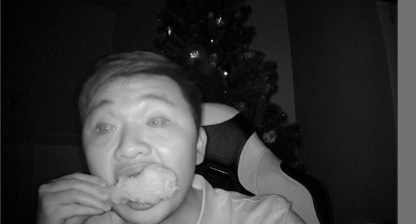

In [ ]:
import onnxruntime
import numpy as np, cv2, torch
from PIL import Image

session = onnxruntime.InferenceSession('out.onnx')

def predict_onnx(img_path):
    img = cv2.imread(img_path, 0)
    img = mmcv.imrescale(img, (224, 416))
    img = mmcv.impad(img, shape=(224, 416), pad_val=114)
    inp = img[None, :224,:,None]
    ort_inputs = {session.get_inputs()[0].name: inp.astype(np.float32)}
    logits = output = session.run(None, ort_inputs)[0]
    output = torch.softmax(torch.from_numpy(output).squeeze(), 0).numpy()
    pred_cls = np.argmax(output)
    score = output[pred_cls]
    return score, pred_cls, logits, img
img_path = df.img_path.iloc[0]
score, pred_cls, logits, img = predict_onnx(img_path)
print(f'{pred_cls=} {score=}')
Image.fromarray(img)

In [ ]:
# img = mmcv.imread(df.iloc[0].img_path)
# print(img.shape)
# img = mmcv.imrescale(img, (416, 416))
# print(img.shape)
# Image.fromarray(img[:224])

### Gửi em ảnh test

In [ ]:
val_ids = df_train.video_index.unique().tolist()
val_json_paths = [list_json_paths[i] for i in val_ids]
# val_json_paths
json_paths = np.random.choice(val_json_paths)
json_paths

{'pred_json_path': '/home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_eating_0001/annotations/pred_mb2_face_food.json',
 'label_path': '/data/DMS_Behavior_Detection/RawVideos/Action_Eating/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_eating_0001.json',
 'video_path': '/data/DMS_Behavior_Detection/RawVideos/Action_Eating/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_eating_0001.mp4',
 'raw_feat_path': '/home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_ea

In [ ]:
from IPython.display import clear_output
cc = CocoDataset(json_paths['pred_json_path'])
label = Label(mmcv.load(json_paths['label_path']), mmcv.VideoReader(json_paths['video_path']))
vis_list = []
raw_feat = read_raw_feat_one_video(json_paths['raw_feat_path'])
def fv(img_id):
    board = Board(num_lines=4, line_w=500)
    frame = cc.visualize(img_id, score_thr=0.05);
    img = cc.gt.imgs[img_id]
    img_path = osp.join(cc.img_dir, img['file_name'])
    score, pred_cls = predict_onnx(img_path)[:2]
    action = _id2action[pred_cls.item()]
    if action != 'none':
        board.set_line_text(1, action, score.item())
    lbl = label.check_action_at_frame_idx(img_id)
    if len(lbl):
        board.set_line_text(2, f'Label: {lbl[0]}')

    vis = board.img_concat(frame)
    return vis
vis_list = multi_thread(fv, cc.img_ids, 8)
clear_output()
images_to_video(vis_list, 'vis.mp4', output_size=(800, 300))

2022-09-20 10:45:26.896 | INFO     | avcv.utils:images_to_video:267 - Write video, output_size: (800, 300)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 872/872, 241.4 task/s, elapsed: 4s, ETA:     0s

2022-09-20 10:45:30.510 | INFO     | avcv.utils:images_to_video:277 - -> /home/anhvth8/gitprojects/YOLOX/vis.mp4
